# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1 - df_test 04-19to04-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1 - df_test 04-19to05-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather']


## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, "1.1 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1 - df_val 01-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [5]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [6]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [7]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-10-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-10-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-09-30 00:00:00
2018-10-01 00:00:00 2018-12-31 00:00:00


In [8]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [10]:
# possible related to the target
# "EXISTE_INHABILITAR", 
to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INVEST"] 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [46]:
# "EXISTE_INHABILITAR"
to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "FECHA_SINI", "EXISTE_INVEST"]
X_full_train = df.drop(to_drop, axis=1)
y_full_train = df["EXISTE_FRAUDE"]

In [12]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [13]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

845753, 120551
845753, 120551


In [14]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.0031959685629255824, 0.0038075171504176656)

## short optimization

In [28]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

#set_rf_samples(60000)

## Defining grid configuration

In [15]:
from sklearn.utils.class_weight import compute_class_weight

In [16]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50155175, 161.60866238])

In [17]:
rf_params = {
#    "n_estimators": [40, 100],
#    "min_samples_leaf": [3, 7],
#    "max_depth": [3, 5, 10],
#    "max_features": ['sqrt', 0.5],
    "class_weight": [{0:1, 1:10}, {0:1, 1:15}, {0:weights[0], 1:weights[1]}]
}

In [18]:
len(X_train) * 0.01

8457.53

In [19]:
# using without grid
rf = RandomForestClassifier(n_estimators=40, max_features="sqrt",
                            min_samples_leaf=100, random_state=random_state, n_jobs=6)
# rf.fit(X_full_train, y_full_train)

In [22]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt 
clf = GridSearch(rf, param_grid=rf_params)
clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring="f1", verbose=True)

Comparing 3 parameter setting(s) using 8 CPU thread(s) ( 1 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [23]:
print("Best Config:")
print(clf.best_params, clf.best_score)

Best Config:
{'class_weight': {0: 1, 1: 10}} 0.548683404776485


In [25]:
print("Grid scores:")
for params, score in zip(clf.params, clf.scores):
    print("%0.3f for %r" % (score, params))

Grid scores:
0.549 for {'class_weight': {0: 1, 1: 10}}
0.540 for {'class_weight': {0: 1, 1: 15}}
0.468 for {'class_weight': {0: 0.5015517477229634, 1: 161.60866238138965}}


In [26]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [27]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.5286525554981931, 0.9852585670326574)

In [28]:
confusion_matrix(y_val, y_val_pred)

array([[105839,    902],
       [    11,    512]])

## dumping best current config

In [205]:
import pickle

In [208]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [29]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
34,EXISTE_INHABILITAR,0.326117
33,COD_RAMO,0.266541
70,COD_ACT_BENEF,0.150469
7,cond_32,0.024956
31,total_condicion,0.024093
11,cond_C11,0.021278
10,cond_C10,0.021040
47,preg_15,0.019407
12,cond_C12,0.017148
32,es_gte_5,0.016809


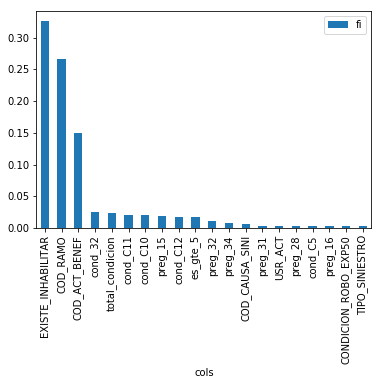

In [30]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [33]:
to_keep = rf_fi[rf_fi["fi"] >=0.005]["cols"].values
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 13 of 148


In [34]:
to_keep

array(['EXISTE_INHABILITAR', 'COD_RAMO', 'COD_ACT_BENEF', 'cond_32',
       'total_condicion', 'cond_C11', 'cond_C10', 'preg_15', 'cond_C12',
       'es_gte_5', 'preg_32', 'preg_34', 'COD_CAUSA_SINI'], dtype=object)

In [35]:
# best model
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [36]:
X_train_red = X_train[to_keep].copy()

In [37]:
print(len(X_train_red.columns))

13


### Training again with less features

In [38]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [39]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.5033751205400193, 0.9942238985476596)

In [40]:
confusion_matrix(y_val, y_val_pred)

array([[105712,   1029],
       [     1,    522]])

In [41]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
1,COD_RAMO,0.384715
0,EXISTE_INHABILITAR,0.340182
2,COD_ACT_BENEF,0.107024
6,cond_C10,0.043382
8,cond_C12,0.032594
7,preg_15,0.027165
4,total_condicion,0.016819
5,cond_C11,0.016501
10,preg_32,0.009390
9,es_gte_5,0.008211


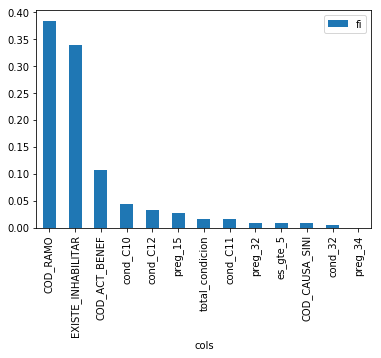

In [42]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [43]:
# best columns used
rf_fi["cols"].values

array(['COD_RAMO', 'EXISTE_INHABILITAR', 'COD_ACT_BENEF', 'cond_C10',
       'cond_C12', 'preg_15', 'total_condicion', 'cond_C11', 'preg_32',
       'es_gte_5', 'COD_CAUSA_SINI', 'cond_32', 'preg_34'], dtype=object)

# final model

In [209]:
# reset_rf_samples()

## full features final model

In [51]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [52]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.541, 0.999


In [53]:
confusion_matrix(y_val, y_val_pred)

array([[105906,    835],
       [    20,    503]])

## red features final model

In [54]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=6, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [55]:
y_val_pred = rf_full.predict(X_val[to_keep])
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val[to_keep])[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.568, 0.999


In [56]:
confusion_matrix(y_val, y_val_pred)

array([[105958,    783],
       [     5,    518]])

## Tronador (sum cond >=5) comparison

In [57]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >=5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3722854188210961,0.8392451283456392)


In [58]:
confusion_matrix(y_val, y_tronador)

array([[105690,   1051],
       [   163,    360]])

# Saving final model & columns used into hard drive

In [170]:
model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [115]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [171]:
# merging list input & target
full_cols = list(to_keep) + ["EXISTE_FRAUDE"]
full_cols

['COD_RAMO',
 'COD_ACT_BENEF',
 'cond_C10',
 'es_gte_5',
 'total_condicion',
 'cond_C11',
 'preg_15',
 'cond_C12',
 'cond_32',
 'preg_31',
 'preg_32',
 'COD_CAUSA_SINI',
 'USR_ACT',
 'preg_34',
 'TIPO_EXPED',
 'preg_33',
 'SEGMENTO',
 'EXISTE_FRAUDE']

In [172]:
columns_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - COLUMNS - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [173]:
# saving for example a few rows to implement the model
df_example = X_val.loc[-100:, to_keep]
df_example["EXISTE_FRAUDE"] = y_val.loc[-100:]
df_example.to_feather("../../models/1.0 - df_train with nan 01-17to12-18/1.0 - dataset example to predict model.feather")

# reloading final model & columns and predict

In [174]:
model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"
with open(model_file, "rb") as file:
    m = pickle.load(file)

In [175]:
m

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [176]:
columns_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - COLUMNS - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"
with open(columns_file, "rb") as file:
    columns = pickle.load(file)

In [177]:
columns

['COD_RAMO',
 'COD_ACT_BENEF',
 'cond_C10',
 'es_gte_5',
 'total_condicion',
 'cond_C11',
 'preg_15',
 'cond_C12',
 'cond_32',
 'preg_31',
 'preg_32',
 'COD_CAUSA_SINI',
 'USR_ACT',
 'preg_34',
 'TIPO_EXPED',
 'preg_33',
 'SEGMENTO',
 'EXISTE_FRAUDE']

In [112]:
y_val_pred = m.predict(X_val[to_keep])
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, m.predict_proba(X_val[to_keep])[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.696, 0.999


In [114]:
confusion_matrix(y_val, y_val_pred)

array([[106293,    448],
       [     5,    518]])

In [178]:
y_example_pred = m.predict_proba(df_example.drop(columns="EXISTE_FRAUDE"))[:, -1]
f1_score(y_val, y_val_pred > 0.5), roc_auc_score(y_val,y_example_pred)

(0.5274949083503055, 0.9987284136224165)